<a href="https://colab.research.google.com/github/arjasc5231/moodots/blob/ACRNN/SER/CNN/ADRNN/ADRNN_ver2_residual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Speech Emotion Recognition From 3D Log-Mel Spectrograms With Deep Learning network를 바탕으로 구현.  

다음 논문의 특징 중  


1.   ACRNN
2.   dilated cnn
3.   batch normalization
4.   leaky relu
5.   residual
6.   center loss
  
1,2,5만 우선 구현

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import numpy as np
import sys
sys.path.append("/content/drive/MyDrive/team_runner/colab/emoDB/CNN")
from kfold import kfold

In [ ]:
X_train, X_test, Y_train, Y_test = np.load("/content/drive/MyDrive/team_runner/colab/dataset/emoDB/emo_mel_3d.npy", allow_pickle=True)
X = np.concatenate((X_train, X_test), axis=0)
Y = np.concatenate((Y_train, Y_test), axis=0)

print(X.shape)
print(Y.shape)

(911, 128, 128, 3)
(911,)


In [ ]:
def create_model():
    inputs = keras.Input(shape=(128, 128, 3))
    conv1 = keras.layers.Conv2D(filters=64, kernel_size=[3, 3], padding='same', activation=tf.nn.relu, kernel_initializer='random_normal')(inputs)
    pool1 = keras.layers.MaxPool2D()(conv1)
    
    conv2 = keras.layers.Conv2D(filters=128, kernel_size=[3, 3], dilation_rate=2, padding='same', activation=tf.nn.relu, kernel_initializer='random_normal')(pool1)
    conv3 = keras.layers.Conv2D(filters=128, kernel_size=[3, 3], dilation_rate=2, padding='same', activation=tf.nn.relu, kernel_initializer='random_normal')(conv2)
    conv4 = keras.layers.Conv2D(filters=128, kernel_size=[3, 3], dilation_rate=2, padding='same', activation=tf.nn.relu, kernel_initializer='random_normal')(conv3)

    conv_res = keras.layers.Conv2D(filters=128, kernel_size=[3, 3], dilation_rate=2, padding='same', kernel_initializer='random_normal')(pool1)
    res = keras.layers.Add()([conv_res,conv4])
    res = keras.layers.ReLU()(res)

    trans = keras.layers.Permute((2,1,3))(res)
    reshape = keras.layers.Reshape((-1, 64*128))(trans) # 열 개수(freq축)*ch
    linear = keras.layers.Dense(512)(reshape)
    """
     # 빠른 overfitting, 65%
    lstm = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=False, dropout=0.5))(linear)

    fc = keras.layers.Dense(128)(lstm)
    """
    lstm = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True, dropout=0.5))(linear) # (time=15,hidden=256)

    attention_score1 = keras.layers.Dense(1, activation='tanh')(lstm) # lstm(time,hidden)*W(hidden,1)=score(time,1)
    attention_score2 = keras.layers.Softmax()(attention_score1)
    attention = keras.layers.Dot(axes=(1,1))([lstm, attention_score2]) # (time=15, hidden=256) * (time,) => (hidden=256)
    flatten = keras.layers.Flatten()(attention)
  
    fc = keras.layers.Dense(128, activation=tf.nn.relu)(flatten)
    
    # 윗 주석은 CRNN, 다음 코드는 ACRNN
    drop = keras.layers.Dropout(0.5)(fc)
    output = keras.layers.Dense(7)(drop)
    return keras.Model(inputs=inputs, outputs=output)

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_65 (Conv2D)              (None, 128, 128, 64) 1792        input_14[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D) (None, 64, 64, 64)   0           conv2d_65[0][0]                  
__________________________________________________________________________________________________
conv2d_66 (Conv2D)              (None, 64, 64, 128)  73856       max_pooling2d_13[0][0]           
___________________________________________________________________________________________

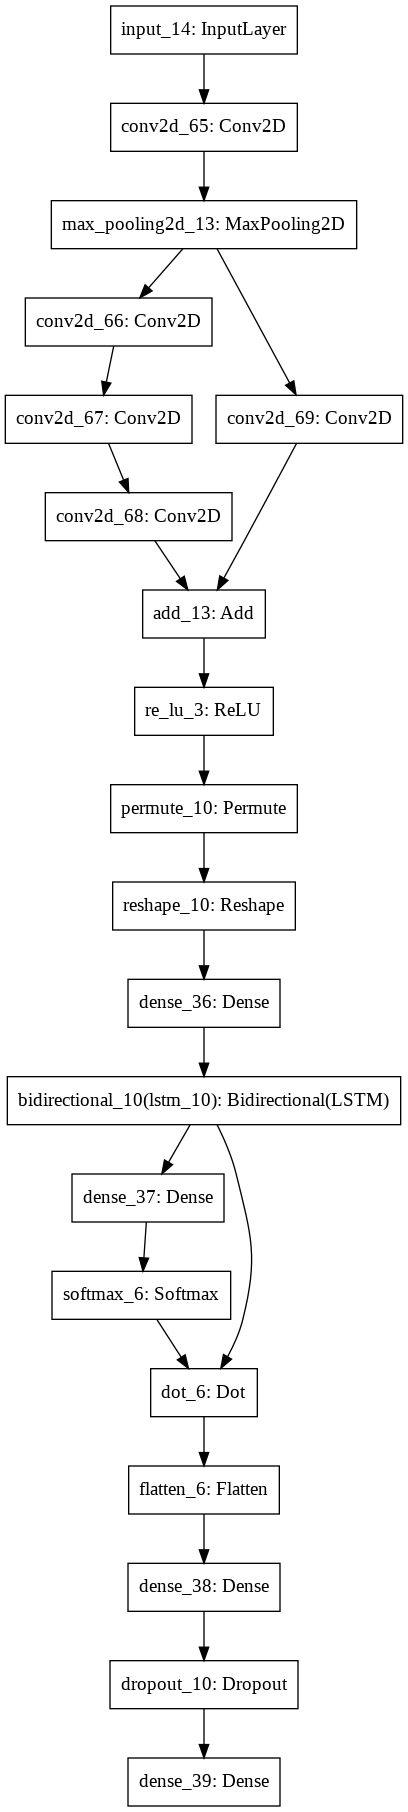

In [ ]:
model = create_model()
model.summary()
keras.utils.plot_model(model)

In [ ]:
kfold(5, create_model, X, Y, 0.001, 100, 120, 1) # CRNN은 안그러는데, ACRNN에서 local optimal에 빠진다. 이를 막으려고 random initialization을 추가했다. 그래도 효과 없네

Learning started. k=5
<<fold 1>>
Epoch	loss		train acc	test acc
1  	22.0990  	0.1848  	0.1943
2  	5.1838  	0.1616  	0.2174
3  	2.0114  	0.2154  	0.2174
4  	1.9435  	0.2154  	0.2174
5  	1.9451  	0.2154  	0.2174
6  	1.9445  	0.1684  	0.1133
7  	1.9430  	0.1284  	0.1133
8  	1.9421  	0.1609  	0.1133
9  	1.9414  	0.1266  	0.1373
